# 04 - Kepler

Notebook constructs Kepler html for San Cristobal de las Casas and Zihuatanejo. (2024 05 03)

## Import modules

In [1]:
# Imports que venían en el Notebook 15-min-city > 13-15-min-kepler-test.ipynb
import io
import boto3
from keplergl import KeplerGl

import os
import sys

import pandas as pd
import geopandas as gpd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [2]:
city = 'San Cristobal'
prox_schema = 'projects_research'
prox_table = 'femsainfancias_missingcities_proxhex'

## Download hexagons with time data

In [3]:
# Download proximity data for city
query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE \"city\" LIKE '{city}'"
hex_gdf = aup.gdf_from_query(query, geometry_col="geometry")

##########
# CHANGES DUE TO NEW PROXIMITY ANALYSIS OUTPUT
# Res 8 only
hex_gdf = hex_gdf.loc[hex_gdf.res == 8].copy()

# Change colnames in current proxanalysis into previously used colnames for columns used in Kepler
hex_gdf.rename(columns={'max_time':'max_idx_15_min',
                        'p_0a14':'pob_0a14',
                        'p_15a24':'pob_15a24',
                        'p_25a59':'pob_25a59',
                        'dens_pob_ha':'dens_pobha'},inplace=True)

# Drop columns that will not be shown in Kepler
hex_gdf.drop(columns=['idx_preescolar','idx_primaria', 'idx_secundaria', 
                      'idx_salud', 'idx_guarderías','idx_asistencia social', 
                      'idx_alimentos', 'idx_personal','idx_farmacias', 'idx_hogar', 'idx_complementarios', 
                      'idx_social','idx_actividad física', 'idx_cultural', 
                      'mean_time', 'median_time','idx_sum'],inplace=True)
##########

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(90, 31)


,hex_id,res,geometry,max_escuelas,max_preescolar,max_primaria,max_secundaria,max_servicios comunitarios,max_salud,max_guarderías,...,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city
0,886d23b169fffff,8,"POLYGON ((-92.68489 16.78370, -92.68050 16.786...",103.04351,8.348399,9.304488,103.04351,125.863549,7.270417,125.863549,...,125.863549,2115.8186,1168.0729,947.74554,771.79541,420.88945,772.75008,150.38344,26.971643,San Cristobal


<Axes: >

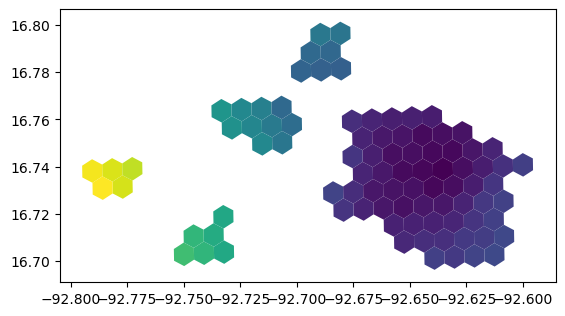

In [4]:
hex_gdf.plot('max_idx_15_min')

## Data treatment

In [5]:
hex_gdf_format = hex_gdf.copy()

#### Data treatment - Find missing amenity when max_idx_15_min is more than 15 mins.
##### (Farthest amenity is what's having a grater impact in proximity, and what __could__ be considered the highest priority).

In [6]:
# All amenity's times to be considered
amenities_list = ['max_preescolar','max_primaria','max_secundaria', #Escuelas
                  'max_salud','max_guarderías','max_asistencia social', #Servicios comunitarios
                  'max_alimentos','max_personal','max_farmacias','max_hogar','max_complementarios', #Comercio
                  'max_social','max_actividad física', 'max_cultural'] #Entretenimiento

# Set missing amenity col name and initial data
missing_column_name = 'Equipamiento/servicio prioritario'
hex_gdf_format[missing_column_name] = 'No aplica'
# Set missing amenity by hex
idx = hex_gdf_format['max_idx_15_min']>15
hex_gdf_format.loc[idx,missing_column_name] = hex_gdf_format[amenities_list].idxmax(axis=1)

# Rename missing amenities found
def missing_amenity(amenity_code):
    dict_names = {'max_preescolar':'Preescolar',
                  'max_primaria':'Primaria',
                  'max_secundaria':'Secundaria',
                  'max_guarderías':'Guardería',
                  'max_salud':'Salud - primer contacto',
                  'max_asistencia social':'Centro de asistencia social',
                  'max_alimentos':'Comercio de productos alimenticios',
                  'max_personal':'Comercio para el cuidado personal',
                  'max_farmacias':'Farmacia',
                  'max_hogar':'Comercio de artículos para el hogar',
                  'max_complementario':'Comercio barrial complementario',
                  'max_social':'Espacios de esparcimiento social',
                  'max_actividad física':'Espacios para la actividad física',
                  'max_cultural':'Espacios de esparcimiento cultural',
                  'No aplica':'No aplica'}
    return dict_names[amenity_code]
hex_gdf_format[missing_column_name] = hex_gdf_format[missing_column_name].apply(missing_amenity)

# Drop amenities list (keeps ejes, max_time, population data)
hex_gdf_format.drop(columns=amenities_list,inplace=True)

# Show
print(hex_gdf_format.shape)
hex_gdf_format.head(1)

(90, 18)


,hex_id,res,geometry,max_escuelas,max_servicios comunitarios,max_comercio,max_entretenimiento,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city,Equipamiento/servicio prioritario
0,886d23b169fffff,8,"POLYGON ((-92.68489 16.78370, -92.68050 16.786...",103.04351,125.863549,10.232064,118.344001,125.863549,2115.8186,1168.0729,947.74554,771.79541,420.88945,772.75008,150.38344,26.971643,San Cristobal,Guardería


#### Data treatment - Change ejes and pop data to make more comprehensible
##### (Adds text that make more comprehensible the data, like ' (pob/ha)' and 'min'(minutes))

In [7]:
format_coldata_list = ['max_idx_15_min','max_escuelas', 'max_servicios comunitarios','max_comercio', 'max_entretenimiento','pobtot',
                       'dens_pobha','pobfem','pobmas','pob_0a14','pob_15a24', 'pob_25a59','p_60ymas']

for c in format_coldata_list:
    if c == 'dens_pobha':
        # Add text ' (pob/ha)' to density
        hex_gdf_format[c] = hex_gdf_format[c].round(2)
        hex_gdf_format[c] = hex_gdf_format[c].astype(str) + ' (pob/ha)'
        
    else:
        # Make sure data is integer
        hex_gdf_format[c] = hex_gdf_format[c].round().astype(int)

        # Full format of max_idx_15_min later, just previous line.
        if c != 'max_idx_15_min':
            # Add text ' min' (minutes) to time data
            if 'max' in c:
                hex_gdf_format[c] = hex_gdf_format[c].astype(str) + ' min'
            # Add nothing to pop data
            else:
                hex_gdf_format[c] = hex_gdf_format[c].astype(str)

# Show
print(hex_gdf_format.shape)
hex_gdf_format.head(1)

(90, 18)


,hex_id,res,geometry,max_escuelas,max_servicios comunitarios,max_comercio,max_entretenimiento,max_idx_15_min,pobtot,pobfem,pobmas,pob_0a14,pob_15a24,pob_25a59,p_60ymas,dens_pobha,city,Equipamiento/servicio prioritario
0,886d23b169fffff,8,"POLYGON ((-92.68489 16.78370, -92.68050 16.786...",103 min,126 min,10 min,118 min,126,2116,1168,948,772,421,773,150,26.97 (pob/ha),San Cristobal,Guardería


#### Data treatment - rename columns that will be shown in Kepler

In [8]:
rename_columns = {'max_escuelas':'Tiempo a escuelas',
                  'max_servicios comunitarios':'Tiempo a servicios comunitarios',
                  'max_comercio':'Tiempo a comercio',
                  'max_entretenimiento':'Tiempo a entretenimiento',
                  'pobtot':'Población total',
                  'dens_pobha':'Densidad de población',
                  'pobfem':'Población femenina',
                  'pobmas':'Población masculina',
                  'pob_0a14':'Población de 0 a 14 años',
                  'pob_15a24':'Población de 15 a 24 años',
                  'pob_25a59':'Población de 25 a 59 años',
                  'p_60ymas':'Población de 60 años y más'}

for c in rename_columns.keys():
    hex_gdf_format.rename(columns={c : rename_columns[c]}, inplace=True)

# Show
print(hex_gdf_format.shape)
hex_gdf_format.head(1)

(90, 18)


,hex_id,res,geometry,Tiempo a escuelas,Tiempo a servicios comunitarios,Tiempo a comercio,Tiempo a entretenimiento,max_idx_15_min,Población total,Población femenina,Población masculina,Población de 0 a 14 años,Población de 15 a 24 años,Población de 25 a 59 años,Población de 60 años y más,Densidad de población,city,Equipamiento/servicio prioritario
0,886d23b169fffff,8,"POLYGON ((-92.68489 16.78370, -92.68050 16.786...",103 min,126 min,10 min,118 min,126,2116,1168,948,772,421,773,150,26.97 (pob/ha),San Cristobal,Guardería


#### Data treatment - Format max_time column

In [9]:
# Create time categories (bins) from column max_idx_15_min --> 'Tiempo máximo a todos los servicios'
max_column = 'max_idx_15_min'
final_max_column = 'Tiempo máximo a todos los servicios'
#final_max_column = 'max_idx_15_min_2'
hex_gdf_format[final_max_column] = hex_gdf_format[max_column].astype(str) + ' min'

# Create time categories (bins) from max_idx_15_min col
bins = [0, 15, 30, 45, 60, hex_gdf_format[max_column].max()]
labels = ['0-15', '15-30', '30-45', '45-60', '60>']
hex_gdf_format[f'bins_{max_column}'] = pd.cut(hex_gdf_format[max_column], bins=bins, labels=labels, include_lowest=True)

# Show
print(hex_gdf_format.shape)
hex_gdf_format.head(1)

(90, 20)


,hex_id,res,geometry,Tiempo a escuelas,Tiempo a servicios comunitarios,Tiempo a comercio,Tiempo a entretenimiento,max_idx_15_min,Población total,Población femenina,Población masculina,Población de 0 a 14 años,Población de 15 a 24 años,Población de 25 a 59 años,Población de 60 años y más,Densidad de población,city,Equipamiento/servicio prioritario,Tiempo máximo a todos los servicios,bins_max_idx_15_min
0,886d23b169fffff,8,"POLYGON ((-92.68489 16.78370, -92.68050 16.786...",103 min,126 min,10 min,118 min,126,2116,1168,948,772,421,773,150,26.97 (pob/ha),San Cristobal,Guardería,126 min,60>


#### Data treatment - Filter and re-order columns of interest

In [10]:
hex_kepler = hex_gdf_format[[final_max_column, 'Tiempo a escuelas', 'Tiempo a servicios comunitarios','Tiempo a comercio', 'Tiempo a entretenimiento',
                             'Población total','Densidad de población','Población femenina','Población masculina',
                             'Población de 0 a 14 años','Población de 15 a 24 años', 'Población de 25 a 59 años','Población de 60 años y más',
                             missing_column_name,'geometry',f'bins_{max_column}']] # .copy().to_json()

# Show
print(hex_kepler.shape)
hex_kepler.head(1)

(90, 16)


,Tiempo máximo a todos los servicios,Tiempo a escuelas,Tiempo a servicios comunitarios,Tiempo a comercio,Tiempo a entretenimiento,Población total,Densidad de población,Población femenina,Población masculina,Población de 0 a 14 años,Población de 15 a 24 años,Población de 25 a 59 años,Población de 60 años y más,Equipamiento/servicio prioritario,geometry,bins_max_idx_15_min
0,126 min,103 min,126 min,10 min,118 min,2116,26.97 (pob/ha),1168,948,772,421,773,150,Guardería,"POLYGON ((-92.68489 16.78370, -92.68050 16.786...",60>


#### Data treatment - ¿?

In [11]:
#hex_kepler['           '] = '         '
#hex_kepler['            '] = '          '

# Show
#print(hex_kepler.shape)
#hex_kepler.head(1)

## Kepler configuration

In [12]:
config,config_idx = aup.kepler_config()

config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"][
    "name"
] = f'bins_{max_column}'

config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
    "Análisis de hexágono"] = [final_max_column, 'Tiempo a escuelas',
                  'Tiempo a servicios comunitarios','Tiempo a comercio',
                  'Tiempo a entretenimiento','           ',
                               'Población total','Densidad de población',
                               'Población femenina','Población masculina',
                               'Población de 0 a 14 años',
                               'Población de 15 a 24 años',
                               'Población de 25 a 59 años',
                               'Población de 60 años y más','            ',
                              missing_column_name]

#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [final_max_column, 'max_escuelas', 'pobtot']

In [13]:
# hex_gdf["d"] = 0
longitude = hex_gdf.dissolve().geometry.centroid.x
latitude = hex_gdf.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)
map_city = KeplerGl(height=800)
map_city.config = config
map_city.add_data(hex_kepler, name='Análisis de hexágono')
map_city.save_to_html(file_name=f"../../../data/processed/femsa_infancias/{city}.html", read_only=False)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to ../../../data/processed/femsa_infancias/San Cristobal.html!


/tmp/ipykernel_50738/3979118182.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_gdf.dissolve().geometry.centroid.x
/tmp/ipykernel_50738/3979118182.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_gdf.dissolve().geometry.centroid.y
